In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
# load functional definitions for activations like softmax
import torch.nn.functional as F
# print utilities with json
import json
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
import timeit
%matplotlib inline

# 1. Quick intro: The simplicity of running an RNN in PyTorch

In [65]:
# We instantiate an RNN layer with the RNN API from nn module
rnn_layer = nn.RNN(input_size=3, hidden_size=3, num_layers=1, batch_first=True)

# Make some fake data
fake_data = [[1, 2, 3], [4, 5, 6], [7, 8, 9], [0, 1, 1]]
fake_data = torch.FloatTensor(fake_data)
print('fake data tensor size: ', fake_data.size())

fake data tensor size:  torch.Size([4, 3])


### 1) Iterate with your own loop (yesss)

In [68]:
H_t = []
h_t_1 = None
for x_t in fake_data:
    # turn into 3-D shape [batch_size, seq_len, feat_dim=3]
    x_t = Variable(x_t).view(1, -1, 3)
    h_t, h_t_1 = rnn_layer(x_t, h_t_1)
    H_t.append(h_t.data[0, 0, :].numpy())
H_t = np.array(H_t)
print(H_t)

[[ 0.95493919  0.93462884  0.42043793]
 [ 0.99886817  0.99992657  0.95321184]
 [ 0.9999764   0.99999982  0.98929018]
 [ 0.76278824  0.5116421   0.72826672]]


### 2) Structure your data batching, and leave it to the framework (yesss too)

In [69]:
h_t_1 = None
x_t = Variable(fake_data).view(1, -1, 3)
H_t, h_t_1 = rnn_layer(x_t, h_t_1)
print(H_t.data.numpy())

[[[ 0.95493919  0.93462884  0.42043793]
  [ 0.99886817  0.99992657  0.95321184]
  [ 0.9999764   0.99999982  0.98929018]
  [ 0.76278824  0.5116421   0.72826672]]]


# 2. Going Deeper: Character prediction RNN-LSTM

#### We'll now proceed to read a text file from our local dir.

In [22]:
MIN_CHARS=5
with open('aliceinwonderland.txt') as txt_f:
    # read the text file
    text = txt_f.read().lower()
# get sentences on line break (yes, a bit vague, but ok for this)
text_sents = list(filter(lambda x: len(x) > 0, text.split('\n')))
print('text corpus length in chars:', len(text))
print('total sentences: ', len(text_sents))

max_len = max(len(s) for s in text_sents)
min_len = min(len(s) for s in text_sents)
print('max sentence len: ', max_len)
print('min sentence len: ', min_len)

print('Example 10 sentences: ')
for i, sent in enumerate(text_sents[:10], start=1):
    print('{} >> {}'.format(i, sent))

chars = sorted(list(set(text)))
print('total chars:', len(chars))
char2idx = dict((c, i) for i, c in enumerate(chars))
idx2char = dict((i, c) for i, c in enumerate(chars))

text corpus length in chars: 71879
total sentences:  1230
max sentence len:  75
min sentence len:  4
Example 10 sentences: 
1 >> i--down the rabbit-hole
2 >> alice was beginning to get very tired of sitting by her sister on the
3 >> bank, and of having nothing to do. once or twice she had peeped into the
4 >> book her sister was reading, but it had no pictures or conversations in
5 >> it, "and what is the use of a book," thought alice, "without pictures or
6 >> conversations?"
7 >> so she was considering in her own mind (as well as she could, for the
8 >> day made her feel very sleepy and stupid), whether the pleasure of
9 >> making a daisy-chain would be worth the trouble of getting up and
10 >> picking the daisies, when suddenly a white rabbit with pink eyes ran
total chars: 57


In [23]:
# We'll print the char2idx to grasp how it looks like
print(json.dumps(char2idx, indent=2))

{
  "\n": 0,
  " ": 1,
  "!": 2,
  "\"": 3,
  "$": 4,
  "%": 5,
  "'": 6,
  "(": 7,
  ")": 8,
  "*": 9,
  ",": 10,
  "-": 11,
  ".": 12,
  "/": 13,
  "0": 14,
  "1": 15,
  "2": 16,
  "3": 17,
  "4": 18,
  "5": 19,
  "6": 20,
  "7": 21,
  "8": 22,
  "9": 23,
  ":": 24,
  ";": 25,
  "?": 26,
  "@": 27,
  "[": 28,
  "]": 29,
  "_": 30,
  "a": 31,
  "b": 32,
  "c": 33,
  "d": 34,
  "e": 35,
  "f": 36,
  "g": 37,
  "h": 38,
  "i": 39,
  "j": 40,
  "k": 41,
  "l": 42,
  "m": 43,
  "n": 44,
  "o": 45,
  "p": 46,
  "q": 47,
  "r": 48,
  "s": 49,
  "t": 50,
  "u": 51,
  "v": 52,
  "w": 53,
  "x": 54,
  "y": 55,
  "z": 56
}


In [24]:
# STATIC GRAPH PROCEDURE to inject data
# taken from Keras example https://github.com/fchollet/keras/blob/master/examples/lstm_text_generation.py
# ----------------------------------------------------------------
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

print('Vectorization...')
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char2idx[char]] = 1
    y[i, char2idx[next_chars[i]]] = 1
print('Done vectorizing...')
print('X data tensor shape: ', X.shape)
print('y data tensor shape: ', y.shape)

nb sequences: 23947
Vectorization...
Done vectorizing...
X data tensor shape:  (23947, 40, 57)
y data tensor shape:  (23947, 57)


**Note how we had to apply a certain maximum sequence length (40), and then we've built a tensor of input chunks of chars X, and a tensor of next chars x[t] named y**

### Gimme some PyTorch, please

Now we can unleash PyTorch capabilities to define the char RNN very simplistically, and process sequences **with true variable length!**

In [25]:
# Make a sentence encoder helper function
def encode_sent(sent):
    x_seq = []
    for ch in sent:
        x_seq.append(char2idx[ch])
    return x_seq

In [26]:
X = []
for i, sentence in enumerate(text_sents):
    # encode each sentence into its char integer code from char2idx dictionary
    X.append(encode_sent(sentence))
print('Resulting encoded sequences: ', len(X))
print('Example 3 encoded sequences: ')
for n, sent in enumerate(X[:3], start=1):
    print(sent)

Resulting encoded sequences:  1230
Example 3 encoded sequences: 
[39, 11, 11, 34, 45, 53, 44, 1, 50, 38, 35, 1, 48, 31, 32, 32, 39, 50, 11, 38, 45, 42, 35]
[31, 42, 39, 33, 35, 1, 53, 31, 49, 1, 32, 35, 37, 39, 44, 44, 39, 44, 37, 1, 50, 45, 1, 37, 35, 50, 1, 52, 35, 48, 55, 1, 50, 39, 48, 35, 34, 1, 45, 36, 1, 49, 39, 50, 50, 39, 44, 37, 1, 32, 55, 1, 38, 35, 48, 1, 49, 39, 49, 50, 35, 48, 1, 45, 44, 1, 50, 38, 35]
[32, 31, 44, 41, 10, 1, 31, 44, 34, 1, 45, 36, 1, 38, 31, 52, 39, 44, 37, 1, 44, 45, 50, 38, 39, 44, 37, 1, 50, 45, 1, 34, 45, 12, 1, 45, 44, 33, 35, 1, 45, 48, 1, 50, 53, 39, 33, 35, 1, 49, 38, 35, 1, 38, 31, 34, 1, 46, 35, 35, 46, 35, 34, 1, 39, 44, 50, 45, 1, 50, 38, 35]


### Building our char-RNN

In [27]:
class charRNN(nn.Module):
    def __init__(self, char_vocab_size, emb_size=15,
                 rnn_size=128, rnn_layers=1, rnn_dropout=0.):
        super(charRNN, self).__init__()
        # build character Embedding layer
        self.emb = nn.Embedding(char_vocab_size, emb_size)
        self.rnn_layers = rnn_layers
        self.rnn_size = rnn_size
        # LSTM layers
        self.lstm = nn.LSTM(input_size=emb_size,
                            hidden_size=rnn_size,
                            num_layers=rnn_layers,
                            dropout=rnn_dropout,
                            batch_first=True,
                            bidirectional=False)
        # FC output layer into num classes (vocab size)
        self.fc = nn.Linear(rnn_size, char_vocab_size)
    
    def forward(self, seq, states=None):
        # input tensor is of shape [batch_size, seq_len]
        # it is a LongTensor containing an integer idx per char per seq
        assert len(seq.size()) == 2, seq.size()
        # project seq through embedding layer
        emb_ch = self.emb(seq)
        # emb_ch ~ [batch_size, seq_len, emb_size]
        H_t, states = self.lstm(emb_ch, states)
        # H_t ~ [batch_size, seq_len, rnn_size]
        # unroll tensor to 2-D to adjust to FC nature
        H_t_u = H_t.contiguous().view(-1, H_t.size(-1))
        # H_t_u ~ [batch_size x seq_len, rnn_size]
        y_t = F.log_softmax(self.fc(H_t_u))
        # return output predicted probs and rnn states
        return y_t, states

    def init_hidden_zero(self, curr_bsz):
        return (Variable(torch.zeros(self.rnn_layers, curr_bsz, self.rnn_size)),
                Variable(torch.zeros(self.rnn_layers, curr_bsz, self.rnn_size)))
        
# instance our lstm model
char_lstm = charRNN(len(char2idx), rnn_size=100, rnn_dropout=0.)
print(char_lstm)

# HELPER FUNCTION WE'LL USE WE'LL SEE WHERE
def repackage_hidden(h):
    # https://github.com/pytorch/examples/blob/master/word_language_model/main.py
    """Wraps hidden states in new Variables, to detach them from their history."""
    if type(h) == Variable:
        return Variable(h.data)
    else:
        return tuple(repackage_hidden(v) for v in h)

charRNN (
  (emb): Embedding(57, 15)
  (lstm): LSTM(15, 100, batch_first=True)
  (fc): Linear (100 -> 57)
)


In [28]:
# build a sentence decoder function to simplify our future calls to check predictions
def decode_pred_sent(pred_sent):
    dec_sent = ''
    for idx in pred_sent:
        dec_sent += idx2char[idx]
    return dec_sent

In [47]:
# Make a text prediction function
def predict_text_from_seed(model, text_seed='alice was beginning ', num_preds=20):
    model.eval()
    # begin heating the lstm with some seed text and predict next num_preds chars
    enc_seed = encode_sent(text_seed)

    # first make the warm up to save into the LSTM states the seed
    states = None
    for code in enc_seed:
        # please note the Volatile keyword: we just want inference, not backprop
        code = Variable(torch.LongTensor([code]).view(1, 1), volatile=True)
        pred_ch, states = model(code, states)

    pred_ch = torch.max(pred_ch, dim=-1)[1]
    # |> symbol serves as a simple prompt to check where does it start the prediction
    resulting_pred = text_seed + '|>' + idx2char[pred_ch.data[0]]
    # Now iterate char by char in a feedback fashion
    for n in range(num_preds):
        pred_ch, states = model(pred_ch.view(1, 1), states)
        pred_ch = torch.max(pred_ch, dim=-1)[1]
        pred_idx = pred_ch.data[0]
        resulting_pred += idx2char[pred_idx]
    return resulting_pred

# predict some chars w/ RANDOM weights
print('resulting text: ', predict_text_from_seed(char_lstm, 'i found a door ', num_preds=100))

resulting text:  i found a door |>about fifteen inches high, and when she was nothing so she had not a curious feeling!" said alice to 


**Observe how we can iterate with external for loops to the LSTM structure, feeding back the data from time-step to time-step, contrary to TensorFlow methodology.**

### Training the model!

In [30]:
def train_seqbyseq_epoch(X, curr_epoch, model, opt, log_freq, stateful=False):
    # A simple training loop sequence by sequence will serve our purposes
    # YES! THAT SIMPLE!!
    # specify we are in train mode (this will set Dropout/BN behaviors to train mode)
    model.train()
    states = model.init_hidden_zero(1)
    tr_losses = []
    for bidx, x in enumerate(X, start=1):
        # clean previous gradients in graph
        opt.zero_grad()
        # build input x and output y
        # output is just a shifted by 1 timestep version of x
        y = x[1:]
        x = x[:-1]
        # format the PyTorch Variables
        y = Variable(torch.LongTensor(y)).view(-1) # y ~ [seq_len]
        x = Variable(torch.LongTensor(x)).view(1, -1) # x ~ [1, seq_len]
        # (1) forward sequence
        if not stateful:
            pred, _ = model(x, states)
        else:
            pred, states = model(x, states)
            states = repackage_hidden(states)
            #raise NotImplementedError('Missing stateful implementation')
        
        # (2) compute loss: Negative Log Likelihood of correct classes
        loss = F.nll_loss(pred, y)
        # (3) backprop gradients
        loss.backward()
        # (4) update parameters
        opt.step()
        if bidx % log_freq == 0 or bidx >= len(X):
            tr_losses.append(loss.data[0])
            print('Batch {:4d}/{:4d} (epoch {:3d}) loss {:.3f}'.format(bidx,
                                                                       len(X),
                                                                       curr_epoch,
                                                                       tr_losses[-1]))
    return tr_losses
            
import timeit # time epochs

char_lstm = charRNN(len(char2idx), rnn_size=100, rnn_dropout=0.)
NUM_EPOCHS=20
LOG_FREQ=400
# we can limit the samples in the dataset to speed up training (this is a toy example, remember)
max_samples = 100
tr_X = X[:max_samples]
opt = optim.Adam(char_lstm.parameters(), lr=0.001)
beg_t = timeit.default_timer()
tr_losses = []
for epoch in range(NUM_EPOCHS):
    # shuffle sentences
    shuffle(tr_X)
    tr_losses += train_seqbyseq_epoch(tr_X, epoch, char_lstm, opt, 400, False)
    end_t = timeit.default_timer()
    print('Elapsed time for epoch {:3d}: {:.3f} s'.format(epoch, end_t - beg_t))
    beg_t = end_t
    # see predictions change
    print('Epoch {} result {}'.format(epoch, '-' * 30))
    print(predict_text_from_seed(char_lstm, text_sents[1], num_preds=30))

Batch  100/ 100 (epoch   0) loss 2.973
Elapsed time for epoch   0: 10.549 s
Epoch 0 result ------------------------------
alice was beginning to get very tired of sitting by her sister on the|>                              
Batch  100/ 100 (epoch   1) loss 2.821
Elapsed time for epoch   1: 11.039 s
Epoch 1 result ------------------------------
alice was beginning to get very tired of sitting by her sister on the|>t ae t ae t ae t ae t ae t ae 
Batch  100/ 100 (epoch   2) loss 2.256
Elapsed time for epoch   2: 12.729 s
Epoch 2 result ------------------------------
alice was beginning to get very tired of sitting by her sister on the|>the the the the the the the th
Batch  100/ 100 (epoch   3) loss 2.258
Elapsed time for epoch   3: 13.086 s
Epoch 3 result ------------------------------
alice was beginning to get very tired of sitting by her sister on the|>the the the the the the the th
Batch  100/ 100 (epoch   4) loss 2.636
Elapsed time for epoch   4: 13.438 s
Epoch 4 result -------------

In [31]:
print(predict_text_from_seed(char_lstm, 'she found a door ', num_preds=100))
print(predict_text_from_seed(char_lstm, text_sents[1], num_preds=100))

she found a door |>nd the was and the was and the was and the was and the was and the was and the was and the was and t
alice was beginning to get very tired of sitting by her sister on the|>was and the was and the was and the was and the was and the was and the was and the was and the was 


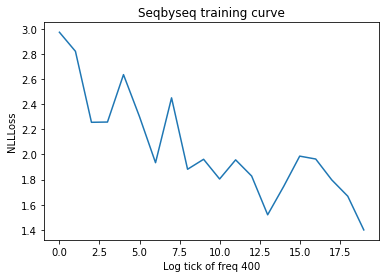

In [32]:
plt.title('Seqbyseq training curve')
plt.ylabel('NLLLoss')
plt.xlabel('Log tick of freq {}'.format(LOG_FREQ))
plt.plot(tr_losses)

### Well look at that learning noise... :( Let's smooth the learning with better updates

In [33]:
def train_batches_epoch(X, batch_size, curr_epoch, model, opt, log_freq):
    # We still need batching with pytorch to smooth our training in the SGD training
    # BUT: Each batch can have a variable length in sequence dimension!!
    # specify we are in train mode (this will set Dropout/BN behaviors to train mode)
    model.train()
    
    n_batches = int(np.ceil(len(X) / batch_size))
    #print('Number of batches with batch_size {}:{}'.format(batch_size, n_batches))
    tr_losses = []
    for bidx, b_beg in enumerate(range(0, len(X), batch_size), start=1):
        left = min(len(X) - b_beg, batch_size)
        states = model.init_hidden_zero(left)
        # select batch of sequences of outputs and inputs
        x_batch = X[b_beg:b_beg + left]
        # get max_len and add PADDING to smaller seqs
        max_batch_len = max(len(s) for s in x_batch)
        min_batch_len = min(len(s) for s in x_batch)
        for s_idx in range(len(x_batch)):
            x_batch[s_idx] = [0] * (max_batch_len - len(x_batch[s_idx])) + x_batch[s_idx]
        x_batch = np.array(x_batch, dtype=np.int64)
        y_batch = x_batch[:, 1:]
        x_batch = x_batch[:, :-1]
        # clean previous gradients in graph
        opt.zero_grad()
        # format the PyTorch Variables
        y = Variable(torch.from_numpy(y_batch).contiguous()).view(-1) # y ~ [batch_size x seq_len]
        x = Variable(torch.from_numpy(x_batch).contiguous()).view(left, -1) # x ~ [batch_size, seq_len]
        # (1) forward sequence
        pred, _ = model(x, states)
        
        # (2) compute loss: Negative Log Likelihood of correct classes
        loss = F.nll_loss(pred, y)
        # (3) backprop gradients
        loss.backward()
        # (4) update parameters
        opt.step()
        if bidx % log_freq == 0 or bidx >= n_batches:
            tr_losses.append(loss.data[0])
            print('Batch {:4d}/{:4d} (epoch {:3d}) loss {:.3f}'.format(bidx,
                                                                       n_batches,
                                                                       curr_epoch,
                                                                       tr_losses[-1]))
    return tr_losses


char_lstm = charRNN(len(char2idx), rnn_size=100, rnn_dropout=0.)
NUM_EPOCHS=20
LOG_FREQ=400
# we can limit the samples in the dataset to speed up training (this is a toy example, remember)
max_samples = 100
tr_X = X[:max_samples]
opt = optim.Adam(char_lstm.parameters(), lr=0.001)
beg_t = timeit.default_timer()
b_tr_losses = []
for epoch in range(NUM_EPOCHS):
    # shuffle sentences
    shuffle(tr_X)
    b_tr_losses += train_batches_epoch(tr_X, 10, epoch, char_lstm, opt, 400)
    end_t = timeit.default_timer()
    print('Elapsed time for epoch {:3d}: {:.3f} s'.format(epoch, end_t - beg_t))
    beg_t = end_t
    # see predictions change
    print('Epoch {} result {}'.format(epoch, '-' * 30))
    print(predict_text_from_seed(char_lstm, text_sents[1], num_preds=30))

Batch   10/  10 (epoch   0) loss 3.921
Elapsed time for epoch   0: 1.363 s
Epoch 0 result ------------------------------
alice was beginning to get very tired of sitting by her sister on the|> an an  an  an  an  an  an  an
Batch   10/  10 (epoch   1) loss 3.291
Elapsed time for epoch   1: 1.411 s
Epoch 1 result ------------------------------
alice was beginning to get very tired of sitting by her sister on the|>                              
Batch   10/  10 (epoch   2) loss 2.935
Elapsed time for epoch   2: 1.435 s
Epoch 2 result ------------------------------
alice was beginning to get very tired of sitting by her sister on the|>                              
Batch   10/  10 (epoch   3) loss 2.996
Elapsed time for epoch   3: 1.398 s
Epoch 3 result ------------------------------
alice was beginning to get very tired of sitting by her sister on the|>                              
Batch   10/  10 (epoch   4) loss 2.759
Elapsed time for epoch   4: 1.614 s
Epoch 4 result ------------------

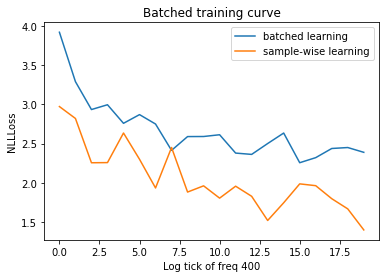

In [35]:
plt.title('Batched training curve')
plt.ylabel('NLLLoss')
plt.xlabel('Log tick of freq {}'.format(LOG_FREQ))
plt.plot(b_tr_losses, label='batched learning')
plt.plot(tr_losses, label='sample-wise learning')
plt.legend()

### Last stage: limiting the max sequence length with statefulness

In [42]:
def train_stateful_maxlen_batches_epoch(X, batch_size, max_len, curr_epoch, model, opt, log_freq, clip=0.):
    # specify we are in train mode (this will set Dropout/BN behaviors to train mode)
    model.train()
    # build a super long sequence out of all samples concatenated
    X_long = []
    for x in X:
        X_long += x
    # trim to multiple of seqlen x batch_size
    X_long = X_long[:batch_size * max_len * (len(X_long) // (batch_size * max_len))]
    X_arr = np.array(X_long, dtype=np.int64).reshape((-1, 1))
    X_arr = X_arr.reshape((batch_size, -1, 1))
    X_arr = np.split(X_arr, X_arr.shape[1] // max_len, axis=1)
    X_arr = np.concatenate(X_arr, axis=0)
    # print('X_arr shape: ', X_arr.shape)
    n_batches = int(np.ceil(X_arr.shape[0] / batch_size))
    # print('Number of batches with batch_size {}: {}'.format(batch_size, n_batches))
    tr_losses = []
    states = model.init_hidden_zero(batch_size)
    for bidx, b_beg in enumerate(range(0, X_arr.shape[0], batch_size), start=1):
        # select batch of sequences of outputs and inputs
        x_batch = X_arr[b_beg:b_beg + batch_size]
        x_batch = np.array(x_batch, dtype=np.int64)
        y_batch = x_batch[:, 1:]
        x_batch = x_batch[:, :-1]
        # clean previous gradients in graph
        opt.zero_grad()
        # format the PyTorch Variables
        y = Variable(torch.from_numpy(y_batch).contiguous()).view(-1) # y ~ [batch_size x seq_len]
        x = Variable(torch.from_numpy(x_batch).contiguous()).view(batch_size, -1) # x ~ [batch_size, seq_len]
        # (1) forward sequence
        pred, states = model(x, states)
        states = repackage_hidden(states)
        # (2) compute loss: Negative Log Likelihood of correct classes
        loss = F.nll_loss(pred, y)
        # (3) backprop gradients
        loss.backward()
        if clip > 0:
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            torch.nn.utils.clip_grad_norm(model.parameters(), clip)

        # (4) update parameters
        opt.step()
        if bidx % log_freq == 0 or bidx >= n_batches:
            tr_losses.append(loss.data[0])
            print('Batch {:4d}/{:4d} (epoch {:3d}) loss {:.3f}'.format(bidx,
                                                                       n_batches,
                                                                       curr_epoch,
                                                                       tr_losses[-1]))
    return tr_losses

In [ ]:
char_lstm = charRNN(len(char2idx), rnn_size=100, rnn_dropout=0.)
NUM_EPOCHS=20
LOG_FREQ=400
# we can limit the samples in the dataset to speed up training (this is a toy example, remember)
max_samples = 100
tr_X = X[:max_samples]
opt = optim.Adam(char_lstm.parameters(), lr=0.001)
beg_t = timeit.default_timer()
st_tr_losses = []
for epoch in range(NUM_EPOCHS):
    # shuffle sentences
    shuffle(tr_X)
    st_tr_losses += train_stateful_maxlen_batches_epoch(tr_X, 10, 35, epoch, char_lstm, opt, 400)
    end_t = timeit.default_timer()
    print('Elapsed time for epoch {:3d}: {:.3f} s'.format(epoch, end_t - beg_t))
    beg_t = end_t
    # see predictions change
    print('Epoch {} result {}'.format(epoch, '-' * 30))
    print(predict_text_from_seed(char_lstm, text_sents[1], num_preds=30))

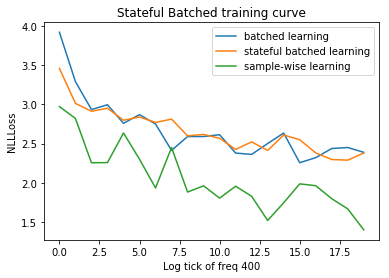

In [37]:
plt.title('Stateful Batched training curve')
plt.ylabel('NLLLoss')
plt.xlabel('Log tick of freq {}'.format(LOG_FREQ))
plt.plot(b_tr_losses, label='batched learning')
plt.plot(st_tr_losses, label='stateful batched learning')
plt.plot(tr_losses, label='sample-wise learning')
plt.legend()

In [38]:
# Now max_len = 15, shorter to backprop less tsteps
char_lstm = charRNN(len(char2idx), rnn_size=100, rnn_dropout=0.)
NUM_EPOCHS=20
LOG_FREQ=400
# we can limit the samples in the dataset to speed up training (this is a toy example, remember)
max_samples = 100
tr_X = X[:max_samples]
opt = optim.RMSprop(char_lstm.parameters(), lr=0.01)
beg_t = timeit.default_timer()
st_sh_tr_losses = []
for epoch in range(NUM_EPOCHS):
    # shuffle sentences
    shuffle(tr_X)
    st_sh_tr_losses += train_stateful_maxlen_batches_epoch(tr_X, 10, 15, epoch, char_lstm, opt, 400)
    end_t = timeit.default_timer()
    print('Elapsed time for epoch {:3d}: {:.3f} s'.format(epoch, end_t - beg_t))
    beg_t = end_t
    # see predictions change
    print('Epoch {} result {}'.format(epoch, '-' * 30))
    print(predict_text_from_seed(char_lstm, text_sents[1], num_preds=30))

Batch   41/  41 (epoch   0) loss 2.239
Elapsed time for epoch   0: 1.228 s
Epoch 0 result ------------------------------
alice was beginning to get very tired of sitting by her sister on the|>she she she she she she she sh
Batch   41/  41 (epoch   1) loss 2.024
Elapsed time for epoch   1: 1.307 s
Epoch 1 result ------------------------------
alice was beginning to get very tired of sitting by her sister on the|>to the to the to the to the to
Batch   41/  41 (epoch   2) loss 2.120
Elapsed time for epoch   2: 1.244 s
Epoch 2 result ------------------------------
alice was beginning to get very tired of sitting by her sister on the|>to the to the to the to the to
Batch   41/  41 (epoch   3) loss 1.877
Elapsed time for epoch   3: 1.266 s
Epoch 3 result ------------------------------
alice was beginning to get very tired of sitting by her sister on the|>was not and the was not and th
Batch   41/  41 (epoch   4) loss 1.799
Elapsed time for epoch   4: 1.310 s
Epoch 4 result ------------------

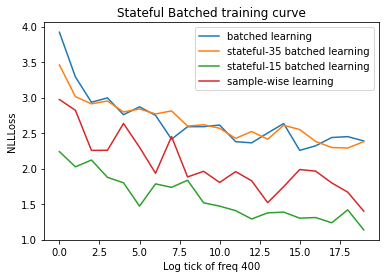

In [39]:
plt.title('Stateful Batched training curve')
plt.ylabel('NLLLoss')
plt.xlabel('Log tick of freq {}'.format(LOG_FREQ))
plt.plot(b_tr_losses, label='batched learning')
plt.plot(st_tr_losses, label='stateful-35 batched learning')
plt.plot(st_sh_tr_losses, label='stateful-15 batched learning')
plt.plot(tr_losses, label='sample-wise learning')
plt.legend()

In [40]:
# Now max_len = 15, shorter to backprop less tsteps
char_lstm = charRNN(len(char2idx), rnn_size=100, rnn_dropout=0.)
NUM_EPOCHS=20
LOG_FREQ=400
# we can limit the samples in the dataset to speed up training (this is a toy example, remember)
max_samples = 100
tr_X = X[:max_samples]
opt = optim.RMSprop(char_lstm.parameters(), lr=0.01)
beg_t = timeit.default_timer()
st_sh_sh_tr_losses = []
for epoch in range(NUM_EPOCHS):
    # shuffle sentences
    shuffle(tr_X)
    st_sh_sh_tr_losses += train_stateful_maxlen_batches_epoch(tr_X, 10, 10, epoch, char_lstm, opt, 400)
    end_t = timeit.default_timer()
    print('Elapsed time for epoch {:3d}: {:.3f} s'.format(epoch, end_t - beg_t))
    beg_t = end_t
    # see predictions change
    print('Epoch {} result {}'.format(epoch, '-' * 30))
    print(predict_text_from_seed(char_lstm, text_sents[1], num_preds=30))

Batch   62/  62 (epoch   0) loss 2.603
Elapsed time for epoch   0: 1.273 s
Epoch 0 result ------------------------------
alice was beginning to get very tired of sitting by her sister on the|>the the the the the the the th
Batch   62/  62 (epoch   1) loss 2.097
Elapsed time for epoch   1: 1.303 s
Epoch 1 result ------------------------------
alice was beginning to get very tired of sitting by her sister on the|>was and the was and the was an
Batch   62/  62 (epoch   2) loss 2.215
Elapsed time for epoch   2: 1.248 s
Epoch 2 result ------------------------------
alice was beginning to get very tired of sitting by her sister on the|>was and the was and the was an
Batch   62/  62 (epoch   3) loss 2.110
Elapsed time for epoch   3: 1.385 s
Epoch 3 result ------------------------------
alice was beginning to get very tired of sitting by her sister on the|>last it was not all the last i
Batch   62/  62 (epoch   4) loss 1.988
Elapsed time for epoch   4: 1.379 s
Epoch 4 result ------------------

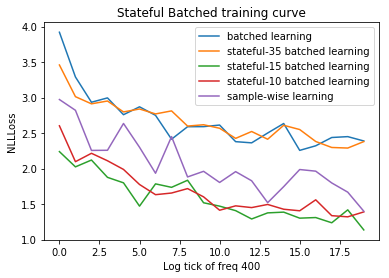

In [41]:
plt.title('Stateful Batched training curve')
plt.ylabel('NLLLoss')
plt.xlabel('Log tick of freq {}'.format(LOG_FREQ))
plt.plot(b_tr_losses, label='batched learning')
plt.plot(st_tr_losses, label='stateful-35 batched learning')
plt.plot(st_sh_tr_losses, label='stateful-15 batched learning')
plt.plot(st_sh_sh_tr_losses, label='stateful-10 batched learning')
plt.plot(tr_losses, label='sample-wise learning')
plt.legend()

In [48]:
# Now max_len = 15, shorter to backprop less tsteps
char_lstm = charRNN(len(char2idx), rnn_size=100, rnn_dropout=0.)
NUM_EPOCHS=20
LOG_FREQ=400
# we can limit the samples in the dataset to speed up training (this is a toy example, remember)
max_samples = 100
tr_X = X[:max_samples]
opt = optim.RMSprop(char_lstm.parameters(), lr=0.01)
beg_t = timeit.default_timer()
st_cn_tr_losses = []
for epoch in range(NUM_EPOCHS):
    # shuffle sentences
    shuffle(tr_X)
    st_cn_tr_losses += train_stateful_maxlen_batches_epoch(tr_X, 10, 35, epoch, char_lstm, opt, 400, 0.2)
    end_t = timeit.default_timer()
    print('Elapsed time for epoch {:3d}: {:.3f} s'.format(epoch, end_t - beg_t))
    beg_t = end_t
    # see predictions change
    print('Epoch {} result {}'.format(epoch, '-' * 30))
    print(predict_text_from_seed(char_lstm, text_sents[1], num_preds=30))

Batch   17/  17 (epoch   0) loss 2.412
Elapsed time for epoch   0: 1.143 s
Epoch 0 result ------------------------------
alice was beginning to get very tired of sitting by her sister on the|> to to to to to to to to to to 
Batch   17/  17 (epoch   1) loss 2.251
Elapsed time for epoch   1: 1.187 s
Epoch 1 result ------------------------------
alice was beginning to get very tired of sitting by her sister on the|> was the was the was the was th
Batch   17/  17 (epoch   2) loss 2.094
Elapsed time for epoch   2: 1.243 s
Epoch 2 result ------------------------------
alice was beginning to get very tired of sitting by her sister on the|> was was was a was was a was wa
Batch   17/  17 (epoch   3) loss 1.845
Elapsed time for epoch   3: 1.556 s
Epoch 3 result ------------------------------
alice was beginning to get very tired of sitting by her sister on the|> was the was the was the was th
Batch   17/  17 (epoch   4) loss 1.687
Elapsed time for epoch   4: 1.455 s
Epoch 4 result --------------

In [52]:
print(predict_text_from_seed(char_lstm, 'she found a door ', num_preds=50))
print(predict_text_from_seed(char_lstm, 'she went ', num_preds=50))
print(predict_text_from_seed(char_lstm, 'when ', num_preds=50))
print(predict_text_from_seed(char_lstm, 'a rabbit ', num_preds=50))
print(predict_text_from_seed(char_lstm, 'a golden key ', num_preds=50))

she found a door |>about with the table, half however, think it was no
she went |>alice was nothing the little the table, half howeve
when |>she was considering how she was considering how she
a rabbit |>was not a moment. she was not a moment. she was not
a golden key |>was nothing the little the table, half however, thi


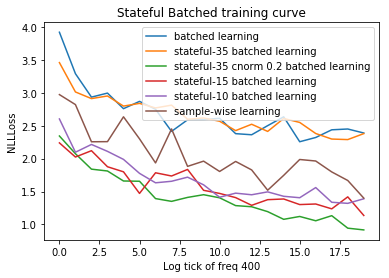

In [44]:
plt.title('Stateful Batched training curve')
plt.ylabel('NLLLoss')
plt.xlabel('Log tick of freq {}'.format(LOG_FREQ))
plt.plot(b_tr_losses, label='batched learning')
plt.plot(st_tr_losses, label='stateful-35 batched learning')
plt.plot(st_cn_tr_losses, label='stateful-35 cnorm 0.2 batched learning')
plt.plot(st_sh_tr_losses, label='stateful-15 batched learning')
plt.plot(st_sh_sh_tr_losses, label='stateful-10 batched learning')
plt.plot(tr_losses, label='sample-wise learning')
plt.legend()

### Proposals to do 

* Change the dataset into another txt file
* Introduce a sequence length filtering in model forward, to **exclude padding positions** in sequence when batching with padding
* Implement a noisy initial hidden state with normal distribution ~ N(0, I)
* Implement a **learnable initial hidden state** (not just zero vector)
* Implement the option to use GRU layers instead of LSTM in the model (BEWARE with cell differences, like states)
* Implement the option to use RNN layers instead of LSTM in the model (BEWARE with cell differences, like states)
* Compare the **performance of RNN vs GRU vs LSTM**, training for 20 epochs with the desired amount of data
* Implement **stateful batched trainer** method (making sample i-th from batch b-th continue in sample i-th from batch (b+1)-th